# house prices advanced regression techniques
We are trying to estimate the prices of houses based on the infomation
The selected performance measure for this problem is Root Mean Square Error (RMSE), which is following;

$ \begin{equation*}
    RMSE(X,h) = \sqrt{\frac{1}{m} \sum^m_{i=1} \left( h(x^{(i)}) - y^{(i)} \right)}^2 
    \end{equation*} $

In [1]:
import os
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error

## Exploratory Analysis

In [2]:
DOWNLOAD_ROOT = 'datasets'
def fetch_data(path=DOWNLOAD_ROOT):
    os.makedirs(path, exist_ok=True)
    os.system('kaggle competitions download -c house-prices-advanced-regression-techniques -p ' + path)
    zip_path = os.path.join(path, 'house-prices-advanced-regression-techniques.zip')
    with ZipFile(zip_path, 'r') as zip:
        zip.extractall(path=path)
        print('successfully fetched datasets at ' + os.path.abspath(path))
        
def load_trainset_testset(path=DOWNLOAD_ROOT):
    train_path = os.path.join(path, 'train.csv')
    test_path = os.path.join(path, 'test.csv')
    
    return pd.read_csv(train_path), pd.read_csv(test_path)

In [3]:
fetch_data()
housing_train, housing_test = load_trainset_testset()

housing_train.head()

successfully fetched datasets at C:\Users\fbab9\OneDrive\Documents\Personal Project\Data-science-portfolio\Notebooks\Supervised\House-price-prediction\datasets


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
housing_train.info()
housing_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


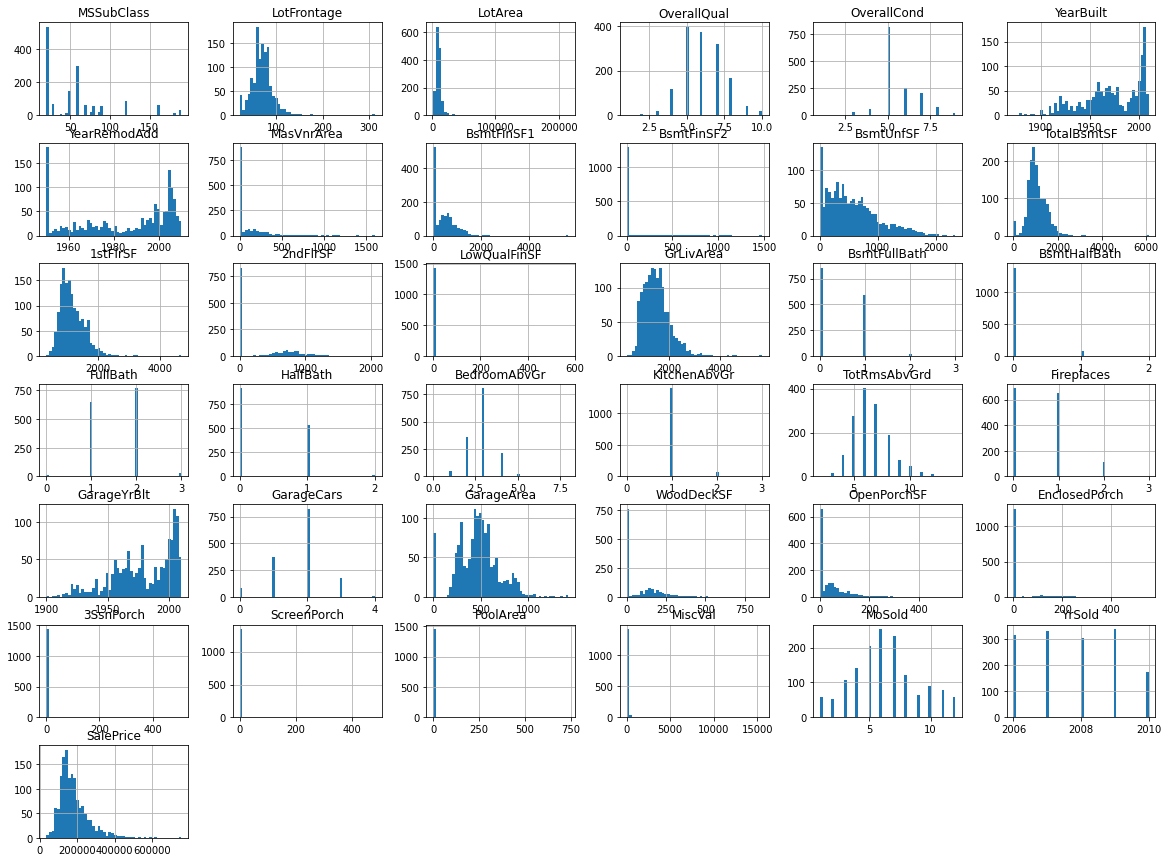

In [5]:
# Id is completely irrelevant for our prediction
test_ids = housing_test['Id'].copy()
housing_train = housing_train.drop('Id', axis=1)
housing_test = housing_test.drop('Id', axis=1)

housing_train.hist(bins=50, figsize=(20,15))
plt.show()

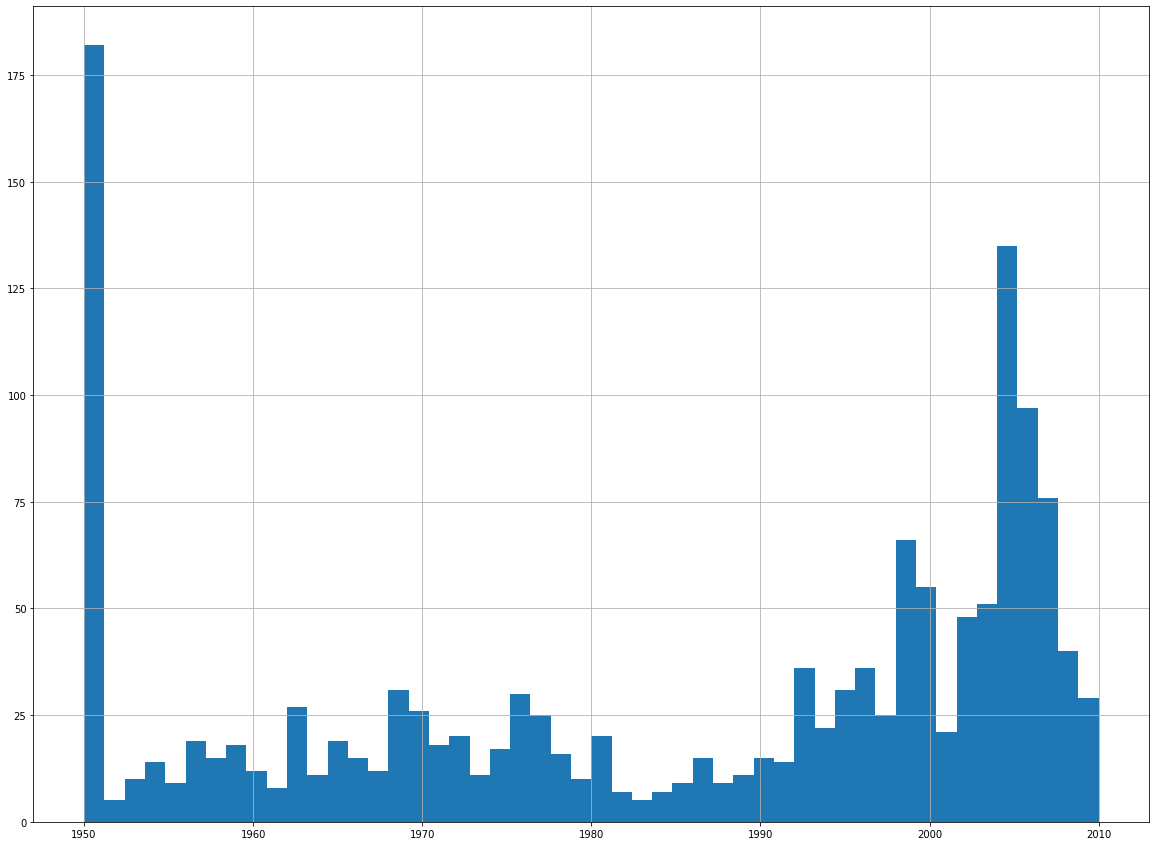

In [6]:
housing_train['YearRemodAdd'].hist(bins=50, figsize=(20,15))
plt.show()

The remodel date seems to be capped at 1950. It would be better to remove data with 1950 as YearRemodAdd.

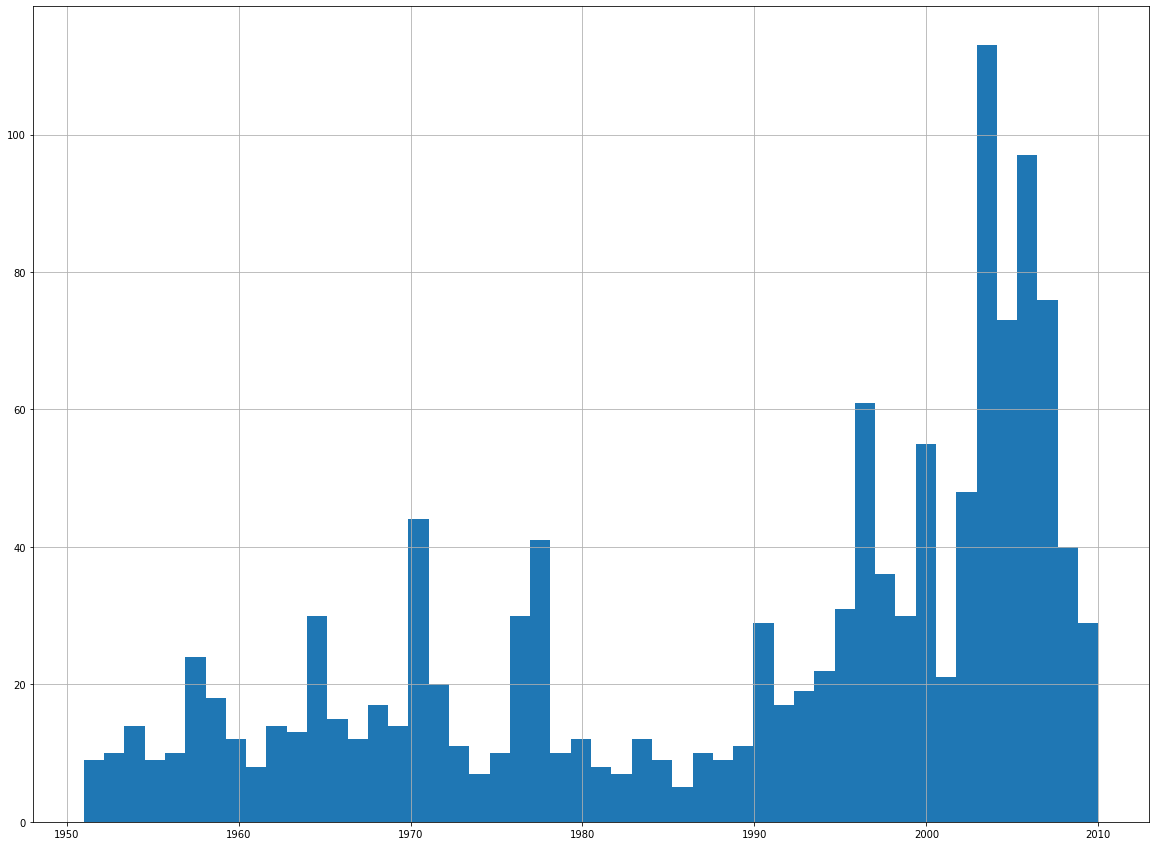

In [7]:
housing_train = housing_train[housing_train['YearRemodAdd'] != 1950]
housing_train['YearRemodAdd'].hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:xlabel='YearBuilt', ylabel='OverallQual'>

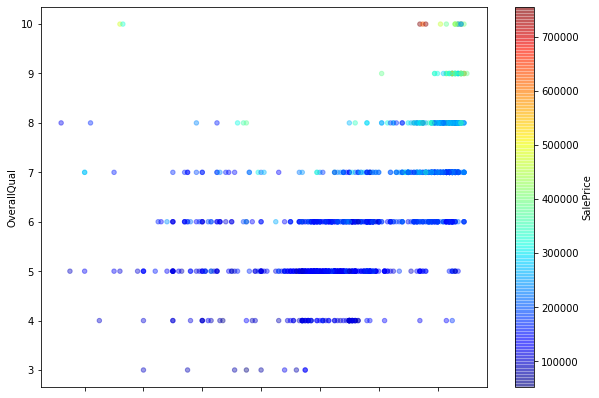

In [8]:
housing = housing_train.copy()

housing.plot(kind='scatter', x='YearBuilt', y='OverallQual', alpha=0.4, figsize=(10,7), c='SalePrice', cmap=plt.get_cmap('jet'), colorbar=True,)

In [9]:
corr_matrix = housing.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.788013
GrLivArea        0.712719
GarageCars       0.632294
GarageArea       0.616062
TotalBsmtSF      0.589496
1stFlrSF         0.579819
FullBath         0.542965
TotRmsAbvGrd     0.542635
Fireplaces       0.467423
YearBuilt        0.467037
MasVnrArea       0.461126
GarageYrBlt      0.452434
YearRemodAdd     0.438158
BsmtFinSF1       0.348256
LotFrontage      0.339317
2ndFlrSF         0.334371
OpenPorchSF      0.319455
WoodDeckSF       0.298080
LotArea          0.255077
HalfBath         0.248902
BsmtUnfSF        0.227661
BsmtFullBath     0.197470
BedroomAbvGr     0.148245
ScreenPorch      0.100095
PoolArea         0.090323
MoSold           0.035852
3SsnPorch        0.033112
LowQualFinSF     0.007868
MiscVal         -0.021305
BsmtHalfBath    -0.029703
YrSold          -0.036347
BsmtFinSF2      -0.039634
EnclosedPorch   -0.073265
MSSubClass      -0.104822
KitchenAbvGr    -0.131169
OverallCond     -0.135752
Name: SalePrice, dtype: float64

In [10]:
housing['HasPool'] = housing['PoolArea'] != 0
housing['Bedrooms_per_room'] = housing['BedroomAbvGr']/housing['TotRmsAbvGrd']
corr_matrix = housing.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice            1.000000
OverallQual          0.788013
GrLivArea            0.712719
GarageCars           0.632294
GarageArea           0.616062
TotalBsmtSF          0.589496
1stFlrSF             0.579819
FullBath             0.542965
TotRmsAbvGrd         0.542635
Fireplaces           0.467423
YearBuilt            0.467037
MasVnrArea           0.461126
GarageYrBlt          0.452434
YearRemodAdd         0.438158
BsmtFinSF1           0.348256
LotFrontage          0.339317
2ndFlrSF             0.334371
OpenPorchSF          0.319455
WoodDeckSF           0.298080
LotArea              0.255077
HalfBath             0.248902
BsmtUnfSF            0.227661
BsmtFullBath         0.197470
BedroomAbvGr         0.148245
ScreenPorch          0.100095
HasPool              0.091629
PoolArea             0.090323
MoSold               0.035852
3SsnPorch            0.033112
LowQualFinSF         0.007868
MiscVal             -0.021305
BsmtHalfBath        -0.029703
YrSold              -0.036347
BsmtFinSF2

It can be seen that a new attribute Bedrooms_per_room is significantly more (linearly) correlated to sales price than just the number of bedrooms. Also, an attribut HasPool gives slightlly better correlation than pool area.

## Preparing data for algorithms

In [11]:
# Separating numeric attributes and non-numeric ones
housing = housing_train.drop('SalePrice', axis=1)
housing_labels = housing_train['SalePrice'].copy()

housing_num = housing.select_dtypes(include=[np.number])
housing_cat = housing.select_dtypes(include='object')

In [12]:
# Create cumstom transformer to add extra numeric attributes
bedrooms_idex, rooms_idex, pool_area_idex = housing_num.columns.get_loc('BedroomAbvGr'), housing_num.columns.get_loc('TotRmsAbvGrd') ,housing_num.columns.get_loc('PoolArea')

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # none
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        bedrooms_per_room = X[:, bedrooms_idex] / X[:, rooms_idex]
        has_pool = X[:, pool_area_idex] != 0
        return np.c_[X, bedrooms_per_room, has_pool]

 My pipeline includes SimpleImputer from sklearn, AttributesAdder I just defined, and StandardScaler for feature scaling.

In [13]:
num_attribs = list(housing_num)
cat_attribs = list(housing_cat)

In [14]:
# Create pipeline for processing numeric attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [15]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

In [16]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


housing_prepared = full_pipeline.fit_transform(housing)


## Select and Train a Model

In [17]:
def display_scores(scores):
    print('scores:', scores)
    print('Mean:', scores.mean())
    print('standard deviation:', scores.std())

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X=housing_prepared, y=housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
print(np.sqrt(lin_mse))

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

display_scores(lin_rmse_scores)

20985.389186381773
scores: [ 27558.92303739  37767.09256359  24201.0270049   43642.78844389
  35787.29063796  49827.01461289  23322.32314711  24912.23749154
  65994.73692405 113765.48115054]
Mean: 44677.89150138614
standard deviation: 26345.762874098087


In [19]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
print(np.sqrt(forest_mse))

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

11685.183172284895
scores: [24915.19108417 28537.1398834  22635.5302393  39167.07992916
 36520.02185098 26691.65286957 23075.86443991 26070.31443615
 44590.56772693 29090.52160495]
Mean: 30129.388406451013
standard deviation: 7047.356541435053


In [20]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300)
ada_reg.fit(housing_prepared, housing_labels)

housing_predictions = ada_reg.predict(housing_prepared)
ada_mse = mean_squared_error(housing_labels, housing_predictions)
print(np.sqrt(ada_mse))

scores = cross_val_score(ada_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
ada_rmse_scores = np.sqrt(-scores)

display_scores(ada_rmse_scores)

22543.936418804686
scores: [25391.64065449 30996.63671511 25882.11003181 41471.30770364
 36731.33069008 33272.3543531  26582.18815755 28021.07226818
 49646.16837072 31218.64184492]
Mean: 32921.34507896097
standard deviation: 7379.087588202624


In [21]:
param_grid = [
    {'n_estimators': [1, 10, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [1, 10], 'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [1, 10, 100]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [1, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [22]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [23]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ['Bedrooms_per_room', 'HasPool']
cat_attribs = list(full_pipeline.named_transformers_['cat'].named_steps['encoder'].categories_[0])
attributes = list(housing_num) + extra_attribs + cat_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.05301114776486979, 'OverallQual'),
 (0.0514278730622916, 'GrLivArea'),
 (0.04812375434487029, 'TotalBsmtSF'),
 (0.03746795193126897, 'GarageCars'),
 (0.03657566745513384, 'GarageArea'),
 (0.029113029281584154, '1stFlrSF'),
 (0.02744987016313043, 'TotRmsAbvGrd'),
 (0.026573902642905017, 'Fireplaces'),
 (0.026153960076090516, 'FullBath'),
 (0.02348421380821285, 'BsmtFinSF1'),
 (0.02293506074774355, 'YearBuilt'),
 (0.020975186973280803, 'GarageYrBlt'),
 (0.020841499955771524, '2ndFlrSF'),
 (0.01956928622289089, 'LotArea'),
 (0.019498686129548422, 'YearRemodAdd'),
 (0.01882029140536556, 'MasVnrArea'),
 (0.015257395069365123, 'OpenPorchSF'),
 (0.01293288552595921, 'Bedrooms_per_room'),
 (0.012021343249812409, 'LotFrontage'),
 (0.0119273792327192, 'BsmtUnfSF'),
 (0.009938701383732368, 'WoodDeckSF'),
 (0.007136957036225582, 'BedroomAbvGr'),
 (0.006537815030478831, 'HalfBath'),
 (0.006264626095998019, 'MoSold'),
 (0.005890987246709472, 'RM'),
 (0.005309890706580237, 'OverallCond'),
 (0.005

In the future, the attribute RH can be dropped.

## Evalution of my model
Unfortunately, the testset does not include labels, thus unable to evaluate my model using testset.

## Solution

In [24]:
final_model = grid_search.best_estimator_

X_test = housing_test.copy()

X_test_prep = full_pipeline.transform(X_test)

y_test_predicted = final_model.predict(X_test_prep)

solution = pd.DataFrame({"id":test_ids, "SalePrice":y_test_predicted})
solution.to_csv("House_price.csv", index = False)

## Conclusion
I learned the basics of data cleaning through this case study. Main takeaways are: 
- Capped data must be dealt with.
- Identifications have no meaning at all for prediction.
- Pipelines should be prepared for both numerical and categorical data.
- When using OneHotEncoder, almost always include an argument: ```handle_unknown="ignore"```
- the score of my model is 0.183 (smaller the better), so there are better models or better ways to hyperparameterise my model.